<a href="https://colab.research.google.com/github/gg-dema/geometric-algebraic-transformer/blob/main/testdeep3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive

In [1]:
from google.colab import drive  #import drive from google colab
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

ROOT = "/content/drive"         #location for the drive

drive.mount(ROOT)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/drive


In [2]:
%cd ./drive/MyDrive/deep

/content/drive/MyDrive/deep


#Set up required packages

In [3]:
!pip install einops optuna pytorch_lightning wget --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.9 MB/s eta 0:00:00


Import required libraries

In [4]:
import random
import h5py
import numpy as np
import torch
import torch.nn as nn
import os
import re
from pathlib import Path
import tqdm
import glob
import h5py
#from torch_scatter import scatter
#from torch_sparse import SparseTensor
#from torch_cluster import radius_graph
#from torch_cluster import radius
#from torch_geometric.nn import fps
from torch.optim.lr_scheduler import ExponentialLR
#import vtk
#from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk, numpy_to_vtkIdTypeArray
from torch.nn.functional import scaled_dot_product_attention
#import trimesh
#from torch_geometric.utils import remove_isolated_nodes
#import potpourri3d as pp3d
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from collections import defaultdict
import wget
import torchmetrics
from einops import rearrange
import optuna
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint

#Set GPU device

In [5]:
device = torch.device("cuda:0")

#Define utils

##Data Investigation

In [6]:
def check_hdf5_samples(file):
    sample_indices = []
    num_groups = 0
    def collect_sample_indices(name, obj):
        if isinstance(obj, h5py.Group):
            match = re.match(r'sample_(\d{4})', name)
            if match:
                try:
                    sample_number = int(match.group(1))
                    sample_indices.append(sample_number)
                except ValueError:
                    pass
    def count_groups(name, obj):
        nonlocal num_groups
        if isinstance(obj, h5py.Group):
            match = re.match(r'sample_\d{4}', name)
            if match:
                num_groups += 1

    with h5py.File(file, "r") as f:
        f.visititems(count_groups)
        f.visititems(collect_sample_indices)

    sample_indices.sort()
    min_index = sample_indices[0] if sample_indices else None
    max_index = sample_indices[-1] if sample_indices else None

    if min_index is not None and max_index is not None:
        missing_indices = [i for i in range(min_index, max_index + 1) if i not in sample_indices]
        repeated_indices = {i for i in sample_indices if sample_indices.count(i) > 1}
    else:
        missing_indices = []
        repeated_indices = []

    # Print results
    print(f"Sample Indices: {sample_indices}")
    print(f"Missing Indices: {missing_indices}")
    print(f"Repeated Indices: {sorted(repeated_indices)}")
    print(f"Number of Groups: {num_groups}")


In [7]:
def check_hdf5_structure(file, start_sample=None, end_sample=None):
    def print_hdf5_item(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(name, ":", obj.shape)
        elif isinstance(obj, h5py.Group):
            print("\n")
            print(name, "(Group)")
            for key in obj.keys():
                print_hdf5_item(name + "/" + key, obj[key])

    with h5py.File(file, "r") as f:
        for key in f.keys():
            if 'sample_' in key:
                try:
                    sample_number = int(key.split('_')[1])
                    if (start_sample is None or sample_number >= start_sample) and \
                       (end_sample is None or sample_number <= end_sample):
                        print_hdf5_item(key, f[key])
                except ValueError:
                    pass

In [8]:
def extract_and_print_global_stats(file):
    stats = defaultdict(lambda: defaultdict(dict))

    def collect_stats(name, obj):
        if isinstance(obj, h5py.Dataset):
            if 'wss' in name or 'pressure' in name:
                data = obj[:]
                dataset_name = name.split('/')[-1]
                stats[dataset_name]['min'] = np.min(data)
                stats[dataset_name]['max'] = np.max(data)
                stats[dataset_name]['mean'] = np.mean(data)
                stats[dataset_name]['std'] = np.std(data)

    with h5py.File(file, "r") as f:
        f.visititems(collect_stats)

    print(f"\nStatistics for {file}:")
    for dataset_name, data in stats.items():
        print(f"\nDataset: {dataset_name}")
        print(f"  Min: {data['min']}")
        print(f"  Max: {data['max']}")
        print(f"  Mean: {data['mean']}")
        print(f"  Standard Deviation: {data['std']}")

In [10]:
def extract_and_plot_sample_stats(file1, file2):
    def extract_sample_stats(file):
        sample_stats = []

        def collect_stats(name, obj):
            if isinstance(obj, h5py.Group):
                if 'pressure' in obj and 'wss' in obj:
                    pressure_data = obj['pressure'][:]
                    wss_data = obj['wss'][:]
                    mean_pressure = np.mean(pressure_data)
                    max_wss = np.max(wss_data)
                    sample_stats.append((mean_pressure, max_wss))

        with h5py.File(file, "r") as f:
            f.visititems(collect_stats)

        return sample_stats

    single_sample_stats = extract_sample_stats(file1)
    bifurcating_sample_stats = extract_sample_stats(file2)

    single_stats_np = np.array(single_sample_stats)
    bifurcating_stats_np = np.array(bifurcating_sample_stats)

    plt.figure(figsize=(10, 6))

    plt.scatter(single_stats_np[:, 0], single_stats_np[:, 1], color='blue', label='Single', alpha=0.6)
    plt.scatter(bifurcating_stats_np[:, 0], bifurcating_stats_np[:, 1], color='red', label='Bifurcating', alpha=0.6)

    plt.xlabel('Mean Pressure')
    plt.ylabel('Max WSS')
    plt.title('Mean Pressure vs Max WSS for Each Sample')
    plt.legend()
    plt.grid(True)

    plt.show()

##Data Preprocessing

In [11]:
def preprocess_hdf5_file(file, label):
    """
    This function computes the mean pressure and max WSS of each sample of the
    file and adds a label. It returns a tensor with shape (num_samples, 3)
    where col1 is for max WSS, col2 is for mean pressure, col3 is for the label.
    """
    total_list = []

    with h5py.File(file, 'r') as f:
        sample_keys = [key for key in f.keys() if key.startswith("sample_")]

        for sample_key in sample_keys:
            wss = torch.from_numpy(f[sample_key]['wss'][()])
            pressure = torch.from_numpy(f[sample_key]['pressure'][()])
            total_list.append([wss, pressure, label])

    pre_mv_tensor = torch.zeros(len(total_list), 3)

    for i, sample in enumerate(total_list):
        max_wss = torch.max(sample[0])
        mean_pressure = torch.mean(sample[1])
        pre_mv_tensor[i][0] = max_wss
        pre_mv_tensor[i][1] = mean_pressure
        pre_mv_tensor[i][2] = sample[2]

    print("Number of samples processed:", len(sample_keys))

    return pre_mv_tensor

##Geometric Algebra Embedding


In [12]:
def scalar_to_mv(tensor):
    """
    This function embeds a tensor of scalars with shape (n_items, ) in the
    geometric algebra.
    """
    n_items = tensor.shape[0]
    n_columns = tensor.shape[1]

    reshaped_tensor = tensor.reshape(n_items, n_columns, 1)

    mv_shape = (n_items, n_columns, 16)
    mv = torch.zeros(mv_shape)

    mv[..., 0] = reshaped_tensor[..., 0]

    return mv

##Geometric Algebra Operators

###Blade operator

In [13]:
grade_components = [1,4,6,4,1]

In [14]:
def blade_operator():
    """
    Generates a blade operator matrix for the geometric algebra

    Args:
        None

    Returns:
        (torch.Tensor): Blade operator matrix.
    """

    mv_dimension = 16
    blade_shape = (mv_dimension,mv_dimension)

    coordinates = []
    start = 0
    for length in grade_components:
        coordinates.append(list(range(start, start + length)))
        start += length

    coord_permutations = [
        [[0,1]],
        [[2,5],[3,6],[4,7]],
        [[8,11],[9,12],[10,13]],
        [[14,15]]
     ]
    blade_mask = []

    w_dimension = len(grade_components)
    for k_grade in range(w_dimension):
        w_blade = torch.zeros(blade_shape)
        for coordinate in coordinates[k_grade]:
            w_blade[coordinate, coordinate] = 1.0
        blade_mask.append(w_blade.unsqueeze(0))

    v_dimension = len(grade_components) - 1
    for k_grade in range(v_dimension):
        v_blade = torch.zeros(blade_shape)
        for coord_to,coord_from in coord_permutations[k_grade]:
            v_blade[coord_from, coord_to] = 1.0
        blade_mask.append(v_blade.unsqueeze(0))

    blade_operator = torch.cat(blade_mask,dim = 0)

    return blade_operator

###Reverse operator

In [15]:
def get_coordinates_range():
    """
    Get the ranges of coordinates for each grade based on the configuration in `global_var`.

    Args:
        None

    Returns:
        (List[List[int]]): List of coordinate ranges for each grade.
    """
    coordinates_range = []

    for grade in range(len(grade_components)):
        start_idx = sum(grade_components[:grade])
        end_idx = sum(grade_components[:grade + 1]) - 1
        coordinate_range = [start_idx,end_idx]
        coordinates_range.append(coordinate_range)

    return coordinates_range

In [16]:
def reverse_operator():
    """
    Generate a reverse operator for the given multivector configuration.

    Args:
        None

    Returns:
        (torch.Tensor): Reverse operator for the multivector space.
    """

    reverse_operator = torch.ones(16)
    *_, bivector_range, trivector_range, _ = get_coordinates_range()

    reverse_range = list(
        range(
            bivector_range[0],
            trivector_range[-1] + 1
         )
     )

    reverse_operator[reverse_range] = -1

    return reverse_operator.to(device)

###Geometric product

In [17]:
link = "https://drive.google.com/uc?export=download&id=1cDI0Eh6hBpHQdE55-Ke0XSpUxcVu0SO9"

In [18]:
def get_guidance_matrix():
    """
    Fetches and loads the guidance matrix from a specified URL,
    saving it locally if not already present.

    Returns:
        (torch.Tensor): A tensor representing the guidance matrix.
    """
    if not os.path.exists("guidance_matrix.pt"):
        matrix_url = link#prefix + global_var['guidance_id']
        matrix_file = wget.download(matrix_url)

    guidance_matrix = product_basis = torch.load("guidance_matrix.pt")
    guidance_matrix = guidance_matrix.to(torch.float32)
    guidance_matrix = guidance_matrix.to_dense()

    return guidance_matrix

In [19]:
def geometric_product(x,y):
    """
    Computes the geometric product of two multivectors using the guidance matrix.

    Args:
        x (torch.Tensor): the first multivector
        y (torch.Tensor): the second multivector

    Returns:
        (torch.Tensor): multivector result of the geometric product
    """

    guidance_matrix = get_guidance_matrix().to(device)

    geom_prod = torch.einsum(
        "i j k, ... j, ... k -> ... i",
        guidance_matrix,
        x,
        y
     )

    return geom_prod

###Inner Product

In [20]:
def inner_product(x,y):
    """
    Computes the inner product of two multivectors.

    Args:
        x (torch.Tensor): the first multivector
        y (torch.Tensor): the second multivector

    Returns:
        (torch.Tensor): result of the inner product
    """

    reverse_x = reverse_operator() * x
    geom_x_y = geometric_product(reverse_x,y)
    inner_product = geom_x_y[..., [0]]

    return inner_product

###Dual operator

In [21]:
def dual_operators():
    """
    Constructs dual operators, including the indices for sign flipping and the sign values.

    Args:
        None

    Returns:
        (Tuple[List[int], torch.Tensor]): Tuple containing a list of indices to mask to perfom dual and
                                          the vector to perfom it. This masked approach make faster the
                                          dual computation when applied to a multivector
    """

    coords_range = get_coordinates_range()

    dual_sign_idxs = [2,4,6,9,12,14]
    dual_signs = [
        1 if i not in dual_sign_idxs else -1
        for i in range(16)
    ][::-1]
    dual_signs = torch.tensor(dual_signs)

    dual_flip = list(
        range(
            coords_range[-1][0],coords_range[0][0]-1,-1
         )
     )

    return dual_flip, dual_signs.to(device)

###Outer product

In [22]:
link = "https://drive.google.com/uc?export=download&id=1nu_eI2SyN4zWRhIDJTsKxBW4b8eq6fPk"

In [23]:
def get_outer_matrix():
    """
    Fetches and loads the outer product guidance matrix
    from a specified URL,  saving it locally if not already present.

    Returns:
        (torch.Tensor): A tensor representing the outer guidance matrix.
    """

    if not os.path.exists("outer_guidance.pt"):
        matrix_url = link #global_var['prefix'] + global_var['outer_id']
        matrix_file = wget.download(matrix_url)

    outer_matrix = torch.load("outer_guidance.pt")
    outer_matrix = outer_matrix.to(torch.float32)
    outer_matrix = outer_matrix.to_dense()

    return outer_matrix

In [24]:
def outer_product(x,y):
    """
    Computes the outer product of two multivectors using the outer guidance matrix.

    Args:
        x (torch.Tensor): the first multivector
        y (torch.Tensor): the second multivector

    Returns:
        (torch.Tensor): multivector result of the outer product
    """

    outer_matrix = get_outer_matrix().to(device)

    outputs = torch.einsum("i j k, ... j, ... k -> ... i", outer_matrix, x, y)
    return outputs

### Join

In [25]:
def join(x,y,ref):
    """
    Computes the join of two multivectors relative to a reference multivector.

    Args:
        x (torch.Tensor): the first multivector
        y (torch.Tensor): the second multivector
        ref (torch.Tensor): the reference multivector, mean over the batch
                            and channels of the entering GATr multivector

    Returns:
        (torch.Tensor): multivector result of the join operation
    """

    dual_flip,dual_signs = dual_operators()
    dual_x = dual_signs * x[...,dual_flip]
    dual_y = dual_signs * y[...,dual_flip]

    outer_prod = outer_product(dual_x, dual_y)
    classic_join = dual_signs * outer_prod[...,dual_flip]
    equi_join = ref[..., [15]] * classic_join

    return equi_join

#Investigate data



##Check for missing or repeated samples

In [26]:
print("\n Single")
check_hdf5_samples("single.hdf5")
print("\n Bifurcating")
check_hdf5_samples("bifurcating.hdf5")


 Single
Sample Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,

##Check structure of the hdf5 files

In [27]:
print("\n Single")
check_hdf5_structure("single.hdf5", start_sample = 0, end_sample = 1)
print("\n Bifurcating")
check_hdf5_structure( "bifurcating.hdf5", start_sample = 0, end_sample = 1)


 Single


sample_0000 (Group)
sample_0000/face : (20946, 3)
sample_0000/inlet_idcs : (265,)
sample_0000/pos : (10475, 3)
sample_0000/pressure : (10475,)
sample_0000/wss : (10475, 3)


sample_0001 (Group)
sample_0001/face : (20548, 3)
sample_0001/inlet_idcs : (271,)
sample_0001/pos : (10276, 3)
sample_0001/pressure : (10276,)
sample_0001/wss : (10276, 3)

 Bifurcating


sample_0000 (Group)
sample_0000/face : (38430, 3)
sample_0000/inlet_idcs : (921,)
sample_0000/pos : (19217, 3)
sample_0000/pressure : (19217,)
sample_0000/wss : (19217, 3)


sample_0001 (Group)
sample_0001/face : (39436, 3)
sample_0001/inlet_idcs : (966,)
sample_0001/pos : (19720, 3)
sample_0001/pressure : (19720,)
sample_0001/wss : (19720, 3)


##Extract global stats for pressure and wall shear stress

In [28]:
extract_and_print_global_stats("single.hdf5")
extract_and_print_global_stats("bifurcating.hdf5")


Statistics for single.hdf5:

Dataset: pressure
  Min: 132708.21875
  Max: 137972.359375
  Mean: 134852.28125
  Standard Deviation: 1374.543701171875

Dataset: wss
  Min: -210.3108367919922
  Max: 340.20452880859375
  Mean: 8.488805770874023
  Standard Deviation: 26.8995361328125

Statistics for bifurcating.hdf5:

Dataset: pressure
  Min: 133300.890625
  Max: 134027.5625
  Mean: 133498.828125
  Standard Deviation: 123.24703979492188

Dataset: wss
  Min: -63.809635162353516
  Max: 48.18938064575195
  Mean: 0.9736822247505188
  Standard Deviation: 8.514182090759277


##Plot sample mean pressure and maximum wss

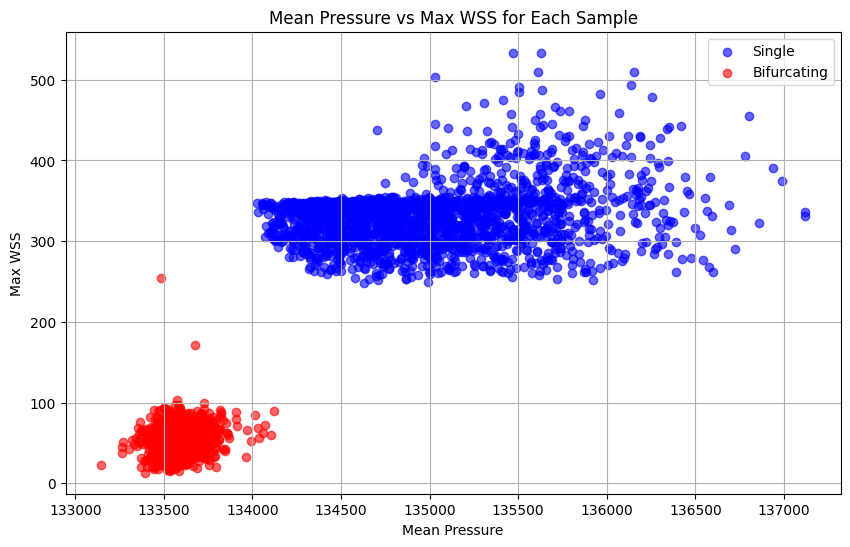

In [29]:
extract_and_plot_sample_stats("single.hdf5", "bifurcating.hdf5")

#Preprocess & combine single and bifurcating data

In [30]:
single_tensor = preprocess_hdf5_file("single.hdf5", 0)
bifurcating_tensor = preprocess_hdf5_file("bifurcating.hdf5", 1)
total_tensor = torch.cat((single_tensor, bifurcating_tensor), dim=0)

Number of samples processed: 2000
Number of samples processed: 1999


#Embed in geometric algebra

In [31]:
mv_tensor = scalar_to_mv(total_tensor)

# Data Module

##Custom Pytorch Dataset

In [120]:
class MultivectorDataset(Dataset):
    def __init__(self, mv_tensor, gatr_flag = True):
        """
        Args:
            mv_tensor (torch.Tensor): Tensor with shape (n_items, 3, 16)
        """
        if gatr_flag:
          self.data = mv_tensor[:, :2, :]  # First two columns as data
          self.data = self.data.unsqueeze(1)
          self.labels = mv_tensor[:, 2, 0]  # Last column as labels
          self.labels = self.labels.unsqueeze(1)
        else:
          self.data = mv_tensor[:, :2, :]  # First two columns as data
          self.labels = mv_tensor[:, 2, 0]  # Last column as labels
          self.labels = self.labels.unsqueeze(1)


    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [122]:
pl.seed_everything(0)

INFO:lightning_fabric.utilities.seed:Seed set to 0


0

In [121]:
class MultivectorDataModule(pl.LightningDataModule):
    """
    Args:
      mv_data (MultivectorDataset): dataset containing all multivectors;
      batch_size (int): size of the batches during training and testing

    Attributes:
      mv_data (MultivectorDataset): dataset containing all multivectors;
      batch_size (int): size of the batches during training and testing;
      data_train (multivector dataset): dataset for train;
      data_val (multivector dataset): dataset for validation;
      data_test (multivector dataset): dataset for test;
    """

    def __init__(self, mv_data, batch_size, gatr_flag):
      super(MultivectorDataModule,self).__init__()
      self.mv_data = mv_data
      self.batch_size = batch_size
      self.gatr_flag = gatr_flag

    def setup(self, stage=None):
        # Split dataset into train, validation, and test splits
      dataset = MultivectorDataset(mv_tensor=self.mv_data, gatr_flag = self.gatr_flag)
      train_len = int(0.8 * len(dataset))
      val_len = int(0.1 * len(dataset))
      test_len = len(dataset) - train_len - val_len

      if stage == 'fit' or stage is None:
            self.data_train, self.data_val, self.data_test = random_split(dataset, [train_len, val_len, test_len])
      elif stage == 'test':
            self.data_test = random_split(dataset, [test_len])[0]
      elif stage == 'predict':
            self.data_test = random_split(dataset, [test_len])[0]

    def train_dataloader(self):
        return DataLoader(self.data_train, shuffle=True, batch_size=self.batch_size, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.data_val, shuffle=False, batch_size=self.batch_size, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.data_test, shuffle=False, batch_size=self.batch_size, num_workers=1)

    def predict_dataloader(self):
        return DataLoader(self.data_test, shuffle=False, batch_size=self.batch_size, num_workers=1)

#GATr layers implementation

##EquiLinearLayer

In [35]:
class EquiLinearLayer(nn.Module):
    """
    Equivariant Linear Layer.

    Args:
        input_mv_channels (int): number of input channels in the multivector
        hidden_mv_dim (int): number of output channels in the multivector
        blade (torch.Tensor): blade tensor representing the geometric entity
        blade_len (int): length of the blade tensor

    Attributes:
        blade (torch.Tensor): blade tensor representing blade operator
        weights (nn.Parameter): learnable weights for the linear layer

    Methods:
        forward(x): computes the forward pass of the equivariant linear layer
    """

    def __init__(self,input_mv_channels,hidden_mv_dim,blade,blade_len):
        super(EquiLinearLayer,self).__init__()
        self.blade = blade
        self.weights = nn.Parameter(
            torch.rand(hidden_mv_dim,input_mv_channels,blade_len, device = device)
         )

    def forward(self,x):
        output_mv = torch.einsum(
            "j i b, b x y, ... i x -> ... j y",
            self.weights,
            self.blade,
            x
         )
        return output_mv

In [123]:
blade = blade_operator().to(device)
blade_len = blade.shape[0]

data_module = MultivectorDataModule(
    mv_data = mv_tensor,
    batch_size = 32,
    gatr_flag = True
)
data_module.setup()
try_train_loader = data_module.train_dataloader()
input_mv, labels = next(iter(try_train_loader))

#print(input_mv.to(device).storage())
#print(device)
#print(input_mv.storage())
input_mv = input_mv.to(device)
labels = labels.to(device)

#input_mv, labels = next(iter(mv_train_loader))

equi_linear = EquiLinearLayer(
    input_mv_channels = input_mv.shape[-2],
    hidden_mv_dim = 8,
    blade = blade,
    blade_len = blade_len
).to(device)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



In [37]:
input_mv.shape, labels.shape

(torch.Size([32, 1, 2, 16]), torch.Size([32, 1]))

In [38]:
equi_linear_input = input_mv
equi_linear_input.storage()
equi_linear_input_shape = equi_linear_input.shape
print(f"[LOG] Input of equilinear layer: {equi_linear_input_shape}")

equi_linear_output = equi_linear(equi_linear_input)
equi_linear_output_shape = equi_linear_output.shape
print(f"[LOG] Output of equilinear layer: {equi_linear_output_shape}")

<ipython-input-38-01c5ebaaeefe>:2: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  equi_linear_input.storage()


[LOG] Input of equilinear layer: torch.Size([32, 1, 2, 16])
[LOG] Output of equilinear layer: torch.Size([32, 1, 8, 16])


##EquiLinearNormalization

In [39]:
class EquilinearNormLayer(nn.Module):
    """
    Custom layer for normalizing multivectors in an equivariant neural network.

    Args:
        faster (bool): flag indicating whether to use the faster inner product calculation

    Attributes:
        faster (bool): flag indicating whether to use the faster inner product calculation

    Methods:
        forward(x): computes the forward pass to normalize multivectors in an equivariant manner
    """

    def __init__(self, faster = True):
        super(EquilinearNormLayer,self).__init__()
        self.faster = faster

    def forward(self, x):
        '''
        if self.faster:
            mv_inner_product = faster_inner_product(x,x)
        else:
        '''
        mv_inner_product = inner_product(x,x)

        squared_norms = torch.mean(mv_inner_product, dim=-2, keepdim=True)

        # Rescale inputs
        outputs = x / torch.sqrt(squared_norms)

        return outputs

In [40]:
#equi_norm = EquilinearNormLayer().to(device)
slow_equi_norm = EquilinearNormLayer(faster=False).to(device)
#syncro = get_device(device)

In [41]:
equi_norm_input = equi_linear_output.to(device)
equi_norm_input_shape = equi_norm_input.shape
input_norm = torch.mean(
    inner_product(equi_norm_input,equi_norm_input),
    dim = -2
)
print(f"\tInput of equilinear norm layer: {equi_norm_input_shape}")
print(f"\tInput mv channel norm: ", torch.mean(input_norm).item())
#print(f"\tInput mv channel norm: ", input_norm[:5])

equi_norm_output = slow_equi_norm(equi_norm_input)
equi_norm_output_shape = equi_norm_output.shape
print(f"\tOutput of equilinear layer: {equi_norm_output_shape}")
normalized_input_norm = torch.mean(
    inner_product(equi_norm_output,equi_norm_output),
    dim = -2
)
print(f"\tOutput mv channel norm: ", torch.mean(normalized_input_norm).item())
#print(f"\tOutput mv channel norm: ", normalized_input_norm[:5])

	Input of equilinear norm layer: torch.Size([32, 1, 8, 16])
	Input mv channel norm:  5867098624.0
	Output of equilinear layer: torch.Size([32, 1, 8, 16])
	Output mv channel norm:  1.0


##Geometric Attention Layer

In [42]:
def prepare_qkv(q,k,v,n_heads,hidden_dim):
    """
    Prepares the query (q), key (k), and value (v) tensors for the
    attention mechanism in a transformer, with the inner product.

    Args:
        q (torch.Tensor): query tensor
        k (torch.Tensor): key tensor
        v (torch.Tensor): value tensor
        n_heads (int): number of attention heads
        hidden_dim (int): hidden dimension

    Returns:
        (torch.Tensor): modified query tensor
        (torch.Tensor): modified key tensor
        (torch.Tensor): modified value tensor
    """

    q = rearrange(
        q,
        "... items (hidden_dim n_heads) mv -> ... n_heads items hidden_dim mv",
        n_heads = n_heads,
        hidden_dim = hidden_dim
     )

    k = rearrange(
        k,
        "... n_items (hidden_dim 1) mv_dim -> ... 1 n_items hidden_dim mv_dim"
     )

    v = rearrange(
        v,
        "... n_items (hidden_dim 1) mv_dim -> ... 1 n_items hidden_dim mv_dim"
     )

    guidance_matrix = get_guidance_matrix().to(device)
    reverse_op = reverse_operator()
    inner_product_mask = (torch.diag(guidance_matrix[0]) * reverse_op).bool()

    ranges = get_coordinates_range()
    index_product_idxs = list(range(ranges[0][0],ranges[-1][-1]+1))
    index_product_coordinates = [
        coord for coord,
        keep in zip(index_product_idxs, inner_product_mask) if keep
     ]

    q = rearrange(
        q[..., index_product_coordinates],
        "... c x -> ... (c x)"
     )
    k = rearrange(
        k[..., index_product_coordinates],
        "... c x -> ... (c x)"
     )

    v = rearrange(
        v,
        "... c x -> ... (c x)"
     )

    return q,k,v

In [43]:
class GeometricAttentionLayer(nn.Module):
    """
    Geometric equivariant attention

    Args:
        mv_channels (int): number of channels in the input multivector
        hidden_dim (int): hidden dimension for attention calculations
        out_channels (int): number of channels in the output multivector
        blade (torch.Tensor): blade tensor representing the geometric entity
        blade_len (int): length of the blade tensor
        n_heads (int): number of attention heads

    Attributes:
        n_heads (int): number of attention heads
        mv_channels (int): number of channels in the input multivector
        hidden_dim (int): hidden dimension for attention calculations
        out_channels (int): number of channels in the output multivector
        q (EquiLinearLayer): layer for queries
        k (EquiLinearLayer): layer for keys
        v (EquiLinearLayer): layer for values
        output_projection (EquiLinearLayer): layer for output projection

    Methods:
        forward(x): computes the forward pass of the geometric attention layer
    """
    def __init__(
        self,mv_channels,hidden_dim,out_channels,blade,blade_len,n_heads
    ):
        super(GeometricAttentionLayer,self).__init__()
        self.n_heads = n_heads
        self.mv_channels = mv_channels
        self.hidden_dim = hidden_dim
        self.out_channels = out_channels

        self.q = EquiLinearLayer(
            input_mv_channels = mv_channels,
            hidden_mv_dim = hidden_dim * n_heads,
            blade = blade,
            blade_len = blade_len
         )

        self.k = EquiLinearLayer(
            input_mv_channels = mv_channels,
            hidden_mv_dim = hidden_dim,
            blade = blade,
            blade_len = blade_len
         )

        self.v = EquiLinearLayer(
            input_mv_channels = mv_channels,
            hidden_mv_dim = hidden_dim,
            blade = blade,
            blade_len = blade_len
         )

        self.output_projection = EquiLinearLayer(
            input_mv_channels = hidden_dim * n_heads,
            hidden_mv_dim = out_channels,
            blade = blade,
            blade_len = blade_len
         )

    def forward(self,x):
        q,k,v = prepare_qkv(
            self.q(x),
            self.k(x),
            self.v(x),
            self.n_heads,
            self.hidden_dim
         )


        attention = scaled_dot_product_attention(q, k, v)
        attention_mv = rearrange(
            attention[..., : self.hidden_dim * x.shape[-1]],
            "... (c x) -> ...  c x", x=x.shape[-1]
         )
        attention_mv = rearrange(
            attention_mv,
            "... heads items hidden_dim x -> ... items (heads hidden_dim) x"
         )

        outputs_mv = self.output_projection(attention_mv)

        return outputs_mv

In [44]:
blade = blade_operator().to(device)
blade_len = blade.shape[0]

geom_attn = GeometricAttentionLayer(
    mv_channels = equi_norm_output_shape[-2],
    hidden_dim = 8,
    out_channels = 8,
    blade = blade,
    blade_len = blade_len,
    n_heads = 4
).to(device)

In [45]:
geo_attn_input = equi_norm_output.to(device)
geo_attn_input_shape = geo_attn_input.shape
print(f"Input of geometric attention layer: {geo_attn_input_shape}")
#print(geo_attn_input.storage())
geo_attn_output = geom_attn(geo_attn_input)
geo_attn_output_shape = geo_attn_output.shape
print(f"Output of geometric attention layer: {geo_attn_output_shape}")
'''
data_sanity_check(
    geo_attn_input.cpu(),
    output_data = geo_attn_output.cpu()
)
'''

Input of geometric attention layer: torch.Size([32, 1, 8, 16])
Output of geometric attention layer: torch.Size([32, 1, 8, 16])


'\ndata_sanity_check(\n    geo_attn_input.cpu(),\n    output_data = geo_attn_output.cpu()\n)\n'

##Residual

In [46]:
res_input_1 = equi_linear_output
res_input_1_shape = res_input_1.shape
print(f"Input 1: pre GATr block equilinear layer: {res_input_1_shape}")

#geo_attn_output incorpora sia il layer lineare precedente che quello successivo
res_input_2 = geo_attn_output
res_input_2_shape = res_input_2.shape
print(f"Input 2: geometric attention layer: {res_input_2_shape}")

res_output = equi_linear_output + geo_attn_output
res_output_shape = res_output.shape
print(f"Output of res connection: {res_output_shape}")

Input 1: pre GATr block equilinear layer: torch.Size([32, 1, 8, 16])
Input 2: geometric attention layer: torch.Size([32, 1, 8, 16])
Output of res connection: torch.Size([32, 1, 8, 16])


##Geometric Bilinear Layer

In [47]:
class GeometricBilinearLayer(nn.Module):
    """
    Geometric bilinear layer.

    Args:
        in_mv_channels (int): number of channels in the input multivector
        hidden_mv_channels (int): number of channels in the hidden multivector

    Attributes:
        geom_linear_1 (EquiLinearLayer): layer for geometric product operand 1
        geom_linear_2 (EquiLinearLayer): layer for geometric product operand 2
        join_linear_1 (EquiLinearLayer): layer for join operand 1
        join_linear_2 (EquiLinearLayer): layer for join operand 2

    Methods:
        forward(x, ref): computes the forward pass of the geometric bilinear layer
    """

    def __init__(self,in_mv_channels,hidden_mv_channels):
        super(GeometricBilinearLayer,self).__init__()

        self.geom_linear_1 = EquiLinearLayer(
            input_mv_channels = in_mv_channels,
            hidden_mv_dim = hidden_mv_channels // 2,
            blade = blade,
            blade_len = blade_len
         )

        self.geom_linear_2 = EquiLinearLayer(
            input_mv_channels = in_mv_channels,
            hidden_mv_dim = hidden_mv_channels // 2,
            blade = blade,
            blade_len = blade_len
         )

        self.join_linear_1 = EquiLinearLayer(
            input_mv_channels = in_mv_channels,
            hidden_mv_dim = hidden_mv_channels // 2,
            blade = blade,
            blade_len = blade_len
         )

        self.join_linear_2 = EquiLinearLayer(
            input_mv_channels = in_mv_channels,
            hidden_mv_dim = hidden_mv_channels // 2,
            blade = blade,
            blade_len = blade_len
         )

    def forward(self,x,ref):
        geom_linear_1 = self.geom_linear_1(x)
        geom_linear_2 = self.geom_linear_2(x)
        geom_product = geometric_product(
            geom_linear_1, geom_linear_2
        ) * 10e-6

        join_linear_1 = self.join_linear_1(x)
        join_linear_2 = self.join_linear_2(x)
        equi_join = join(join_linear_1, join_linear_2, ref)
        outputs_mv = torch.cat((geom_product, equi_join), dim=-2)

        return outputs_mv

In [48]:
# Mean over each batch element (each item of each channel)
ref = torch.mean(input_mv, dim = 2, keepdim = True)
print(ref.shape)
geo_bi = GeometricBilinearLayer(
    in_mv_channels = 8, #global_var['hidden_dim']
    hidden_mv_channels = 8 #global_var['hidden_dim']
).to(device)

torch.Size([32, 1, 1, 16])


In [49]:
geo_bi_input = res_output
geo_bi_input_shape = geo_bi_input.shape
print(f"Input of geometric bilinear layer: {geo_bi_input_shape}")

geo_bi_output = geo_bi(geo_bi_input,ref)
geo_bi_output_shape = geo_bi_output.shape
print(f"Output of geometric attention layer: {geo_bi_output_shape}")

Input of geometric bilinear layer: torch.Size([32, 1, 8, 16])
Output of geometric attention layer: torch.Size([32, 1, 8, 16])


## Gated GELU

In [50]:
class GatedGELU(nn.Module):
    """
    Gated GeLU activation

    Attributes:
        gelu (nn.GELU): GELU activation function

    Methods:
        forward(x): computes the forward pass of the Gated GeLU layer
    """

    def __init__(self):
        super(GatedGELU,self).__init__()
        self.gelu = nn.GELU()

    def forward(self,x):
        gates = x[...,[0]]
        weights = self.gelu(gates)
        outputs = weights * x
        return outputs

In [51]:
gated_gelu = GatedGELU()

gelu_equilinear = EquiLinearLayer(
    input_mv_channels = 8, #global_var['hidden_dim'],
    hidden_mv_dim = 8, #global_var['hidden_dim'],
    blade = blade,
    blade_len = blade_len
).to(device)

In [52]:
gated_gelu_input = geo_bi_output
gated_gelu_input_shape = gated_gelu_input.shape
print(f"Input of equilinear norm layer: {gated_gelu_input_shape}")

gated_gelu_output = gated_gelu(gated_gelu_input)
gated_gelu_output_shape = gated_gelu_output.shape
print(f"Output of GELU layer: {gated_gelu_output_shape}")


gelu_equilinear_input = gated_gelu_output
gelu_equilinear_output = gelu_equilinear(gelu_equilinear_input)
gelu_equilinear_output_shape = gelu_equilinear_output.shape
print(f"Output of equilinear layer: {gelu_equilinear_output_shape}")

Input of equilinear norm layer: torch.Size([32, 1, 8, 16])
Output of GELU layer: torch.Size([32, 1, 8, 16])
Output of equilinear layer: torch.Size([32, 1, 8, 16])


##Final equilinear layer

In [53]:
classes = 2

In [54]:
sigmoid = nn.Sigmoid()
accuracy_meter = torchmetrics.classification.Accuracy(
    task = "binary",
    num_classes = 2
).to(device)
criterion = nn.BCELoss()

final_equilinear = EquiLinearLayer(
    input_mv_channels = 8, #global_var['hidden_dim'],
    hidden_mv_dim = 1,
    blade = blade.to(device),
    blade_len = blade_len
).to(device)

output_projection = nn.Linear(
    input_mv.shape[1],
    classes -1 #global_var['classes'] - 1
).to(device)

In [55]:
final_equilinear_input = gelu_equilinear_output.to(device)
final_equilinear_shape = final_equilinear_input.shape
print(f"Input of final equilinear layer: {final_equilinear_shape}")

final_equilinear_output = final_equilinear(final_equilinear_input)
final_equilinear_output_shape = final_equilinear_output.shape
print(f"Output of final equilinear layer: {final_equilinear_output_shape}")

# final_equilinear_output[:,:,0,:][...,[0]] means
# select from the mvunique channel the scalar component
extracted_scalars = final_equilinear_output[:,:,0,:][...,[0]].squeeze(-1)
extracted_scalars_shape = extracted_scalars.shape
print(f"Extracted scalars: {extracted_scalars_shape}")

proj_extracted_input = output_projection(extracted_scalars)
proj_extracted_input_shape = proj_extracted_input.shape
print(f"Proj scalars: {proj_extracted_input_shape}")

probabilities = sigmoid(proj_extracted_input)
probabilities_shape = probabilities.shape
print(f"Sigmoid output: {probabilities_shape}")

loss = criterion(probabilities,labels.float().to(device))
print(f"Dummy loss: {loss.item():.4f}")

accuracy = accuracy_meter(probabilities,labels.float().to(device))
print(f"Dummy accuracy: {accuracy.item():.4f}")

Input of final equilinear layer: torch.Size([32, 1, 8, 16])
Output of final equilinear layer: torch.Size([32, 1, 1, 16])
Extracted scalars: torch.Size([32, 1])
Proj scalars: torch.Size([32, 1])
Sigmoid output: torch.Size([32, 1])
Dummy loss: 65.6250
Dummy accuracy: 0.3438


#GATr model

##Pytorch module

In [56]:
class GATrNet(nn.Module):
    """
    GATr neural network.

    Args:
        in_channels (int): Number of input channels in the data
        blade (torch.Tensor): Blade tensor for EquilinearLayer operations
        blade_len (int): Length of the blade tensor
        hidden_dim (int): Hidden dimension of the EquilinearLayer

    Attributes:
        enter_equilinear (EquiLinearLayer): EquilinearLayer for initial projection
        attention_equinorm (EquilinearNormLayer): EquilinearNormLayer for attention block normalization
        geometric_attention (GeometricAttentionLayer): GeometricAttentionLayer for attention block
        bilinear_equinorm (EquilinearNormLayer): EquilinearNormLayer for bilinear block normalization
        geometric_bilinear (GeometricBilinearLayer): GeometricBilinearLayer for bilinear block
        gated_gelu (GatedGELU): Gated GELU activation function
        gelu_equilinear (EquiLinearLayer): EquilinearLayer for final GELU operation
        final_equilinear (EquiLinearLayer): Final EquilinearLayer for output projection
        vectorizer (nn.Linear): Linear layer for vectorization

    Methods:
        forward(x): computes the forward pass of the GATrNet
    """

    def __init__(self,in_channels,blade,blade_len,hidden_dim):
        super(GATrNet, self).__init__()

        # Entering Equilinear Layer
        self.enter_equilinear = EquiLinearLayer(
            input_mv_channels = in_channels,
            hidden_mv_dim = hidden_dim,
            blade = blade,
            blade_len = blade_len
         )

        # Attention block
        self.attention_equinorm = EquilinearNormLayer()

        self.geometric_attention = GeometricAttentionLayer(
            mv_channels = hidden_dim,
            hidden_dim = hidden_dim,
            out_channels = hidden_dim,
            blade = blade,
            blade_len = blade_len,
            n_heads = 2 #global_var['n_heads']
         )

        # Bilinear block
        self.bilinear_equinorm = EquilinearNormLayer()

        self.geometric_bilinear = GeometricBilinearLayer(
            in_mv_channels = hidden_dim,
            hidden_mv_channels = hidden_dim,
         )

        self.gated_gelu = GatedGELU()

        self.gelu_equilinear = EquiLinearLayer(
            input_mv_channels = hidden_dim,
            hidden_mv_dim = hidden_dim,
            blade = blade,
            blade_len = blade_len
         )

        # Final Equilinear Layer
        self.final_equilinear = EquiLinearLayer(
            input_mv_channels = hidden_dim,
            hidden_mv_dim = classes - 1, #global_var['classes'] - 1,
            blade = blade,
            blade_len = blade_len
         )

        # Vectorizer
        self.vectorizer = nn.Linear(
            1, #global_var['data_crop'],
            classes - 1 #global_var['classes'] - 1
         )

    def forward(self,x):
        # Entering Equilinear Layer
        projected_in_mv = self.enter_equilinear(x)
        #print(projected_in_mv.shape)
        # Attention block
        normalized_in_mv = self.attention_equinorm(
            projected_in_mv
         )
        #print(normalized_in_mv.shape)

        attended_mv = self.geometric_attention(
            normalized_in_mv
         )
        #print(attended_mv.shape)
        # Residual connection 1
        residual_mv_1 = attended_mv + projected_in_mv
        #print(residual_mv_1.shape)
        # Bilinear block
        reference = torch.mean(x, dim = (1,2), keepdim = True)

        #reference = torch.mean(x, dim = (1,2), keepdim = True)
        #reference = torch.mean(x, dim = 3 , keepdim = True)
        #print("Reference" + str(reference.shape))

        normalized_residual_mv = self.bilinear_equinorm(
            residual_mv_1
         )
        #print(normalized_residual_mv.shape)

        bilinear_mv = self.geometric_bilinear(
            normalized_residual_mv,
            reference
         )

        gated_mv = self.gated_gelu(bilinear_mv)

        projected_bilinear_mv = self.gelu_equilinear(
            gated_mv
         )

        # Residual connection 2
        residual_mv_2 = projected_bilinear_mv + residual_mv_1

        # Final Equilinear Layer
        output_mv = self.final_equilinear(residual_mv_2)

        extracted_scalars = output_mv[:,:,0,:][...,[0]].squeeze(-1)
        logits = self.vectorizer(extracted_scalars)

        return logits

In [57]:
blade = blade_operator().to(device)
blade_len = blade.shape[0]
gatr = GATrNet(
    input_mv.shape[-2],
    blade,
    blade_len,
    8 #global_var['hidden_dim']
).to(device)

total_params = sum(p.numel() for p in gatr.parameters())
print(f"Numero totale di parametri del modello: {total_params}")

Numero totale di parametri del modello: 5402


In [58]:
gatr_input = input_mv
gatr_input_shape = gatr_input.shape
print(f"[LOG] Input of GATr: {gatr_input_shape}")

gatr_output = gatr(gatr_input)
gatr_output_shape = gatr_output.shape
print(f"[LOG] Output of GATr: {gatr_output_shape}")

[LOG] Input of GATr: torch.Size([32, 1, 2, 16])
[LOG] Output of GATr: torch.Size([32, 1])


##Pytorch Lightning module

In [102]:
class GATr(pl.LightningModule):
    """
    LightningModule for training and evaluation of the GATrNet neural network.

    Args:
        in_channels (int): Number of input channels in the data
        blade (torch.Tensor): Blade tensor for EquilinearLayer operations
        blade_len (int): Length of the blade tensor
        hidden_dim (int): Hidden dimension of the EquilinearLayer
        lr (float): Learning rate for optimization
        gamma (float): Gamma parameter for the learning rate scheduler

    Attributes:
        criterion (nn.BCELoss): Binary Cross Entropy Loss for training
        accuracy_meter (torchmetrics.classification.Accuracy): Accuracy metric for binary classification
        lr (float): Learning rate for optimization
        gamma (float): Gamma parameter for the learning rate scheduler
        sigmoid (nn.Sigmoid): Sigmoid activation function
        gatr (GATrNet): GATrNet neural network

    Methods:
        forward(x): computes the forward pass of the GATrNet
        configure_optimizers(): configures the optimizer and learning rate scheduler
        training_step(batch, batch_idx): performs a training step with the given batch
        validation_step(batch): performs a validation step with the given batch
        test_step(batch): performs a test step with the given batch
        predict_step(batch): performs a prediction step with the given batch
    """

    def __init__(self,in_channels,blade,blade_len,hidden_dim,lr,gamma):
        super(GATr, self).__init__()
        self.criterion = nn.BCELoss()
        self.accuracy_meter = torchmetrics.classification.Accuracy(
            task = "binary",
            num_classes = 2
         )
        self.save_hyperparameters()
        self.lr = lr
        self.gamma = gamma
        self.sigmoid = nn.Sigmoid()
        self.gatr = GATrNet(
            in_channels,
            blade,
            blade_len,
            hidden_dim
         )

    def forward(self, x):
        out = self.gatr(x)
        return out

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.lr)
        scheduler = ExponentialLR(optimizer, gamma = self.gamma)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1,
             }
         }


    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = self.gatr(inputs)

        probabilities = self.sigmoid(outputs)
        train_loss = self.criterion(probabilities,labels.float())
        train_accuracy = self.accuracy_meter(probabilities,labels.float())

        values = {"train_loss": train_loss, "train_acc": train_accuracy}
        self.log_dict(values, prog_bar = True)

        return train_loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs, labels = inputs.to(device),labels.to(device)
        outputs = self.gatr(inputs)

        probabilities = self.sigmoid(outputs)
        val_loss = self.criterion(probabilities,labels.float())
        val_accuracy = self.accuracy_meter(probabilities,labels.float())
        values = {"val_loss": val_loss, "val_acc": val_accuracy}
        self.log_dict(values, prog_bar = True)

        return val_loss

    def test_step(self, batch):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = self.gatr(inputs)

        probabilities = self.sigmoid(outputs)
        test_loss = self.criterion(probabilities,labels.float())
        test_accuracy = self.accuracy_meter(probabilities,labels.float())

        values = {"test_loss": test_loss, "test_acc": test_accuracy}
        self.log_dict(values, prog_bar = True)

        return test_loss

    def predict_step(self, batch):
        inputs, _ = batch
        inputs = inputs.to(device)
        predictions = self.gatr(inputs)
        probabilities = self.sigmoid(predictions)
        return torch.round(probabilities)

##Hyperparameters search

In [98]:
def optuna_callback(study, trial):
    """
    Callback that prints the information from the hyperparameters search

    Args:
        study (optuna.Study): Hyperpaameter optimization wrapper
        trial (optuna.Trial): Current values in the optimization process
    Returns:
        Prints logs about current study trial
    """
    string_prefix = "\033[1m\033[94m**********************  Trial "
    string_msg = f"{trial.number + 1}/5"#{global_var['optuna_trial']}"
    string_suffix = " ended *******************************\033[0m"
    print(string_prefix + string_msg + string_suffix)

In [99]:
def hyperparameter_search(name,objective,trials):
    """
    Function for hyperparameter search using Optuna.

    Args:
        name (str): Name of the search
        objective (function): Objective function for hyperparameter optimization
        trials (int): Number of trials for the optimization process

    Returns:
        (Tuple): Best hyperparameters and the Optuna study object
    """

    best_hyperparameters = []
    prefix_string = "\033[1m\033[94m" + "*"*30
    suffix_string = "*"*30 + "\033[0m"
    print(prefix_string + " Hyperparameter search started " + suffix_string)

    sampler = optuna.samplers.TPESampler(
        seed = 0#global_var['sampler_seed']
     )

    study = optuna.create_study(
        direction = "minimize",
        sampler = sampler,
        study_name = "Transformer_hyperparameter_search"
     )

    study.optimize(
        objective,
        n_trials = trials,
        callbacks = [optuna_callback]
     )

    print(prefix_string + " Hyperparameter search ended " + suffix_string)
    print("\nBest objective function value:", study.best_trial.values[0])
    print("Best Hyperparameters", study.best_params)

    best_hyperparameters.append(study.best_params["hidden_dim"])
    best_hyperparameters.append(round(study.best_params["learning_rate"],5))
    best_hyperparameters.append(round(study.best_params["scheduler_gamma"],2))
    best_hyperparameters.append(study.best_params["batch_size"])

    return best_hyperparameters, study

In [106]:
def gatr_objective(trial):
    """
    Objective function for hyperparameter optimization using Optuna.
    This function trains a GATr model on the VesselDataModule
    for a given set of hyperparameters and returns the validation loss.

    Args:
        trial (optuna.Trial): Optuna trial object for hyperparameter optimization

    Returns:
        (float): Validation loss after training the Transformer model
    """

    hidden_dim = trial.suggest_int("hidden_dim",2,8,step = 2)
    learning_rate = trial.suggest_float("learning_rate",1e-2,1e-1)
    scheduler_gamma = trial.suggest_float("scheduler_gamma",0.96,0.99)
    batch_size = trial.suggest_int("batch_size",20,60,step = 10)


    datamodule = MultivectorDataModule(
        mv_data = mv_tensor,
        batch_size = batch_size
     )

    blade = blade_operator().to(device)
    blade_len = blade.shape[0]

    hyper_opt_model = GATr(
        in_channels = 2,#global_var['input_channels'],
        blade = blade,
        blade_len = blade_len,
        hidden_dim = hidden_dim,
        lr = learning_rate,
        gamma = scheduler_gamma
     )

    trainer = pl.Trainer(
        max_epochs = 5,
        logger = False,
        enable_checkpointing = False
     )
    trainer.fit(hyper_opt_model,datamodule)

    return trainer.logged_metrics["val_loss"].item()

In [107]:
[best_hidden_dim, best_lr, best_gamma, best_batch_size], study = hyperparameter_search(
    name = "GATr Hyperparameter Search",
    objective = gatr_objective,
    trials = 5 #global_var['optuna_trial']
)

[I 2024-06-18 14:25:07,775] A new study created in memory with name: Transformer_hyperparameter_search
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | criterion      | BCELoss        | 0      | train
1 | accuracy_meter | BinaryAccuracy | 0      | train
2 | sigmoid        | Sigmoid        | 0      | train
3 | gatr           | GATrNet        | 3.1 K  | train
----------------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


****************************** Hyperparameter search started ******************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-18 14:25:27,503] Trial 0 finished with value: 54.8872184753418 and parameters: {'hidden_dim': 6, 'learning_rate': 0.07436704297351776, 'scheduler_gamma': 0.9780829012821493, 'batch_size': 40}. Best is trial 0 with value: 54.8872184753418.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | criterion      | BCELoss        | 0      | train
1 | accuracy_meter | BinaryAccuracy | 0      | train
2 | sigmoid        | Sigmoid        | 0      | train
3 | gatr     

**********************  Trial 1/5 ended *******************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-18 14:25:42,049] Trial 1 finished with value: 51.87969970703125 and parameters: {'hidden_dim': 4, 'learning_rate': 0.06813047017599906, 'scheduler_gamma': 0.9731276163378808, 'batch_size': 60}. Best is trial 1 with value: 51.87969970703125.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | criterion      | BCELoss        | 0      | train
1 | accuracy_meter | BinaryAccuracy | 0      | train
2 | sigmoid        | Sigmoid        | 0      | train
3 | gatr   

**********************  Trial 2/5 ended *******************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-18 14:26:06,964] Trial 2 finished with value: 51.62907409667969 and parameters: {'hidden_dim': 8, 'learning_rate': 0.04450973669432, 'scheduler_gamma': 0.9837517511424799, 'batch_size': 40}. Best is trial 2 with value: 51.62907409667969.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | criterion      | BCELoss        | 0      | train
1 | accuracy_meter | BinaryAccuracy | 0      | train
2 | sigmoid        | Sigmoid        | 0      | train
3 | gatr      

**********************  Trial 3/5 ended *******************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-18 14:26:47,650] Trial 3 finished with value: 50.62656784057617 and parameters: {'hidden_dim': 6, 'learning_rate': 0.0933036974463395, 'scheduler_gamma': 0.9621310817459365, 'batch_size': 20}. Best is trial 3 with value: 50.62656784057617.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | criterion      | BCELoss        | 0      | train
1 | accuracy_meter | BinaryAccuracy | 0      | train
2 | sigmoid        | Sigmoid        | 0      | train
3 | gatr    

**********************  Trial 4/5 ended *******************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-06-18 14:27:02,619] Trial 4 finished with value: 45.864662170410156 and parameters: {'hidden_dim': 2, 'learning_rate': 0.08493578609931442, 'scheduler_gamma': 0.9833447025284955, 'batch_size': 60}. Best is trial 4 with value: 45.864662170410156.


**********************  Trial 5/5 ended *******************************
****************************** Hyperparameter search ended ******************************

Best objective function value: 45.864662170410156
Best Hyperparameters {'hidden_dim': 2, 'learning_rate': 0.08493578609931442, 'scheduler_gamma': 0.9833447025284955, 'batch_size': 60}


In [64]:
optimization_landscape = optuna.visualization.plot_contour(
    study,
    params = ["hidden_dim", "learning_rate"],
    target_name = "Validation Loss"
)
optimization_landscape.update_layout(
    title_text = 'GATr Optimization Landscape',
    showlegend = True
)
optimization_landscape.show()

In [65]:
def train(name,datamodule,model):
    """
    Function to train a PyTorch Lightning model.

    Args:
        name (str): Name of the training session
        datamodule (pl.LightningDataModule): PyTorch Lightning DataModule for training
        model (pl.LightningModule): PyTorch Lightning model to be trained
    """

    tb_logger = TensorBoardLogger("/content/lightning_logs", name = name)
    checkpoint_callback = ModelCheckpoint(filename = name)
    callbacks = [TQDMProgressBar(refresh_rate = 20),checkpoint_callback]

    trainer = pl.Trainer(
        max_epochs = 20,#global_var['epochs'],
        callbacks = callbacks,
        logger = tb_logger,
        default_root_dir = "/content"
     )

    trainer.fit(model, datamodule)

In [66]:
gatr_datamodule = MultivectorDataModule(
    mv_data = mv_tensor,
    batch_size = best_batch_size
)

blade = blade_operator().to(device)
blade_len = blade.shape[0]
gatr_model = GATr(
    in_channels = 2, #global_var['input_channels'],
    blade = blade,
    blade_len = blade_len,
    hidden_dim = best_hidden_dim,
    lr = best_lr,
    gamma = best_gamma
)

train(
    name = "GATr",
    datamodule = gatr_datamodule,
    model = gatr_model
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | criterion      | BCELoss        | 0      | train
1 | accuracy_meter | BinaryAccuracy | 0      | train
2 | sigmoid        | Sigmoid        | 0      | train
3 | gatr           | GATrNet        | 3.1 K  | train
----------------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


# Transformer

In [108]:
import os
import random
import math

from functools import partial # fix some parameters of a function and generate a new function
from tqdm.notebook import tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt

# utility torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    %pip install --quiet pytorch-lightning
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [109]:
def scaled_dot_product(q_vect, k_vect, v_vect, mask=None):
    dim_key_vect = k_vect.size()[-1]
    attention_logits = torch.matmul(q_vect, k_vect.transpose(-2, -1)) / math.sqrt(dim_key_vect)
    if mask is not None:
        attention_logits = attention_logits.masked_fill(mask == 0, -9e15)

    attention_weights = F.softmax(attention_logits, dim=-1)
    values = torch.matmul(attention_weights, v_vect)
    return values, attention_weights
seq_len, dim_k = 3, 30
Q_mat = torch.rand((seq_len, dim_k))
K_mat = torch.rand((seq_len, dim_k))
V_mat = torch.rand((seq_len, dim_k))
values, attention = scaled_dot_product(Q_mat, K_mat, V_mat)
V_mat, values

(tensor([[0.3076, 0.8143, 0.4394, 0.0142, 0.9149, 0.6631, 0.0638, 0.0827, 0.0607,
          0.6848, 0.6121, 0.3743, 0.2836, 0.9236, 0.9303, 0.5075, 0.8102, 0.7465,
          0.6458, 0.3175, 0.7547, 0.4696, 0.7149, 0.2834, 0.6743, 0.5362, 0.2367,
          0.7505, 0.6941, 0.4342],
         [0.1769, 0.5744, 0.6039, 0.7789, 0.6705, 0.1970, 0.8808, 0.6720, 0.9215,
          0.1787, 0.1479, 0.8980, 0.6080, 0.0852, 0.5667, 0.4687, 0.2606, 0.4640,
          0.6296, 0.7112, 0.0108, 0.3995, 0.5090, 0.3479, 0.0365, 0.9183, 0.7525,
          0.7081, 0.2819, 0.4067],
         [0.7803, 0.5903, 0.7707, 0.7538, 0.2804, 0.1144, 0.7229, 0.8441, 0.5238,
          0.2668, 0.8078, 0.0566, 0.3803, 0.3008, 0.4035, 0.5926, 0.0200, 0.5655,
          0.9931, 0.0046, 0.8140, 0.0041, 0.6614, 0.9649, 0.7582, 0.0415, 0.9727,
          0.2550, 0.1500, 0.4698]]),
 tensor([[0.4628, 0.6408, 0.6331, 0.5780, 0.5675, 0.2783, 0.6111, 0.5976, 0.5402,
          0.3417, 0.5406, 0.4142, 0.4316, 0.3844, 0.5887, 0.5304, 0.2963,

In [110]:
# X = batch * seq_len * dim_hidden_state

# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is

def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask


class MultiHead(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_heads):
        super(MultiHead, self).__init__()

        assert hidden_dim % num_heads == 0, "latent dimension must be divisible by the number of heads"

        self.num_heads = num_heads
        self.embedding_dim = hidden_dim
        self.input_dim = input_dim
        self.dim_head = hidden_dim // num_heads

        self.qkv_projection = nn.Linear(input_dim, 3 * hidden_dim)
        self.my_projection = nn.Linear(hidden_dim, hidden_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.qkv_projection.weight)
        self.qkv_projection.bias.data.fill_(0)

        nn.init.xavier_uniform_(self.my_projection.weight)
        self.my_projection.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_len, _ = x.size()

        if mask is not None:
            mask = expand_mask(mask)

        qkv = self.qkv_projection(x)
        qkv = qkv.reshape(batch_size, seq_len, self.num_heads, 3 * self.dim_head)
        q, k, v = qkv.chunk(3, dim=-1)

        values, attention = scaled_dot_product(q, k, v, mask)
        values = values.permute(0, 2, 1, 3) # batch, seq_len, num_heads, self.embedding_dim
        values = values.reshape(batch_size, seq_len, self.embedding_dim)

        if return_attention:
            return self.my_projection(values), attention
        return self.my_projection(values)

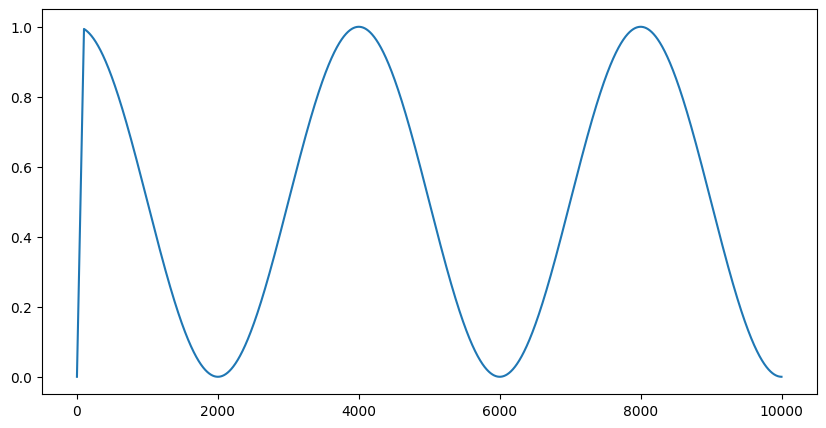

In [136]:
class Encoder(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforwards, dropout=0.0):
        super(Encoder, self).__init__()

        self.multi_head = MultiHead(input_dim, input_dim, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(input_dim, dim_feedforwards),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforwards, input_dim),
        )
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        print(x.shape)
        _, values = self.multi_head(x, mask)
        x = x + self.dropout(values) # residual connection
        x = self.norm1(x)

        lin_output = self.feedforward(x)
        x = x + self.dropout(lin_output)
        x = self.norm2(x)
        return x

class PositionalEmbedding(nn.Module):

    def __init__(self, input_dim, max_seq_len=512):
        super(PositionalEmbedding, self).__init__()

        embedd = torch.zeros(max_seq_len, input_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, input_dim, 2).float() * (-math.log(10000.0) / input_dim))
        embedd[:, 0::2] = torch.sin(position * div_term)
        embedd[:, 1::2] = torch.cos(position * div_term)
        embedd = embedd.unsqueeze(0)

        self.register_buffer('embedding', embedd)

        #self.token_embedding = nn.Linear(input_dim, input_dim)
        #self.position_embedding = nn.Parameter(torch.randn(max_position, 1, input_dim))
        #self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        return x + self.embedding[:, :x.size(1)]



class Transformer(nn.Module):

    def __init__(self, num_layers, input_dim, num_heads, dim_feedforwards, dropout):
        super(Transformer, self).__init__()

        self.encoder = nn.ModuleList([
            Encoder(input_dim, num_heads, dim_feedforwards, dropout) for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        for layer in self.encoder:
            x = layer(x, mask)
        return x

    def get_attention_map(self, x, mask=None):
        attention_maps = []
        for layer in self.encoder:
            _, attention = layer(x, mask, return_attention=True)
            attention_maps.append(attention)
        return _, attention_maps
class WarmupScheduler(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_number_iters=-1):
        self.warmup = warmup
        self.max_number_iters = max_number_iters
        super(WarmupScheduler, self).__init__(optimizer)


    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch  / self.max_number_iters))
        if epoch < self.warmup:
            lr_factor *= epoch / self.warmup
        return lr_factor


p = nn.Parameter(torch.randn(1, 3, 4))
optimizer = torch.optim.Adam([p], lr=1e-3)
lr_scheduler = WarmupScheduler(optimizer, warmup=100, max_number_iters=2000)

epochs = list(range(10000))
plt.figure(figsize=(10, 5))
plt.plot(epochs, [lr_scheduler.get_lr_factor(epoch) for epoch in epochs])

In [137]:
import torch.optim as optim
class TransformerArc(nn.Module):

        def __init__(self,
                     input_dim,
                     hidden_dim,
                     max_seq_len,
                     num_heads,
                     dim_feedforwards,
                     num_layers,
                     output_dim,
                     dropout=0.1,
                     num_classes=2,
                     ):

            super(TransformerArc, self).__init__()

            self.input_net = nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(input_dim, hidden_dim),
            )

            self.positional_embedding = PositionalEmbedding(hidden_dim, max_seq_len=max_seq_len)
            self.transformer = Transformer(num_layers, input_dim, num_heads, dim_feedforwards, dropout)
            self.output_net = nn.Sequential(
                nn.Linear(hidden_dim, output_dim),
                nn.LayerNorm(output_dim),
                nn.Dropout(dropout),
                nn.Linear(output_dim,num_classes),
            )


        def forward(self, x, mask=None):
            x = self.input_net(x)
            x = self.positional_embedding(x)
            x = self.transformer(x, mask)
            x = self.output_net(x)
            return x
class TransformerArchitecture(pl.LightningModule):

    def __init__(self):
        super(TransformerArchitecture, self).__init__()


        input_dim = 16
        hidden_dim = 16
        max_seq_len = 1000
        num_heads = 8
        dim_feedforwards = 512
        num_layers = 2
        output_dim = 256

        # training parameters:
        self.lr = 1e-3
        self.warmup = 0.01
        self.max_iters = 10000
        #self.device = torch.device("cuda:0")# if torch.cuda.is_available() else "cpu")

        self.net = TransformerArc(input_dim,
                                  hidden_dim,
                                  max_seq_len,
                                  num_heads,
                                  dim_feedforwards,
                                  num_layers,
                                  output_dim,
                                  dropout=0.1,
        )
    def forward(self, x, mask=None):
        return self.net(x, mask)


    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)

        # Apply lr scheduler per step
        lr_scheduler = WarmupScheduler(optimizer,
                                             warmup=self.warmup,
                                             max_number_iters=self.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = self.net(inputs)

        probabilities = self.sigmoid(outputs)
        train_loss = self.criterion(probabilities,labels.float())
        train_accuracy = self.accuracy_meter(probabilities,labels.float())

        values = {"train_loss": train_loss, "train_acc": train_accuracy}
        self.log_dict(values, prog_bar = True)

        return train_loss

    def validation_step(self, batch, batch_idx):

        inputs, labels = batch
        inputs, labels = inputs.to(device),labels.to(device)
        outputs = self.net(inputs)

        probabilities = self.sigmoid(outputs)
        val_loss = self.criterion(probabilities,labels.float())
        val_accuracy = self.accuracy_meter(probabilities,labels.float())

        values = {"val_loss": val_loss, "val_acc": val_accuracy}
        self.log_dict(values, prog_bar = True)

        return val_loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = self.net(inputs)

        probabilities = self.sigmoid(outputs)
        test_loss = self.criterion(probabilities,labels.float())
        test_accuracy = self.accuracy_meter(probabilities,labels.float())

        values = {"test_loss": test_loss, "test_acc": test_accuracy}
        self.log_dict(values, prog_bar = True)

        return test_loss

In [138]:
transformer_datamodule = MultivectorDataModule(
   mv_data = mv_tensor,
   batch_size = 16,
   gatr_flag = False
)

In [125]:
device

device(type='cuda', index=0)

In [139]:
transformer_model = TransformerArchitecture()

In [140]:
train(
    name = "Tr",
    datamodule = transformer_datamodule,
    model = transformer_model
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type           | Params | Mode 
------------------------------------------------
0 | net  | TransformerArc | 41.8 K | train
------------------------------------------------
41.8 K    Trainable params
0         Non-trainable params
41.8 K    Total params
0.167     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



torch.Size([16, 2, 16])


ValueError: too many values to unpack (expected 2)